In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torch.autograd import Variable

if not os.path.exists('results'):
    os.mkdir('results')

batch_size = 100
latent_size = 20

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        D_in = 784
        H = 400
        D_out = 784

        self.linear1 = torch.nn.Linear(D_in, H)
        self.enc_mu = torch.nn.Linear(H, latent_size)
        self.enc_log_variance = torch.nn.Linear(H, latent_size)

        self.decodelinear1 = torch.nn.Linear(latent_size, H)
        self.decodelinear2 = torch.nn.Linear(H, D_out)

    def encode(self, x):
        # The encoder will take an input of size 784, and will produce two vectors of size latent_size (corresponding to the coordinatewise means and log_variances)
        # It should have a single hidden linear layer with 400 nodes using ReLU activations, and have two linear output layers (no activations)
        # TODO
        x = F.relu(self.linear1(x))
        mu = self.enc_mu(x)
        log_variance = self.enc_log_variance(x)

        return mu, log_variance

    def reparameterize(self, means, log_variances):
        # The reparameterization module lies between the encoder and the decoder
        # It takes in the coordinatewise means and log-variances from the encoder (each of dimension latent_size),
        # and returns a sample from a Gaussian with the corresponding parameters

        # TODO What is log variances?

        # #TODO what does Variable Do?
        vector_size = log_variances.size()
        epsilon = torch.randn_like(log_variances).to(device)
        std = log_variances.mul(0.5).exp_()
        return epsilon.mul(std).add_(means) #TODO Mult by std not ?

    def decode(self, z):
        # The decoder will take an input of size latent_size, and will produce an output of size 784
        # It should have a single hidden linear layer with 400 nodes using ReLU activations, and use Sigmoid activation for its outputs
        x = F.relu(self.decodelinear1(z))
        mu = torch.sigmoid(self.decodelinear2(x))
        return mu

    def forward(self, x):
        # Apply the VAE encoder, reparameterization, and decoder to an input of size 784
        # Returns an output image of size 784, as well as the means and log_variances, each of size latent_size (they will be needed when computing the loss)
        # TODO
        x = x.view(x.size(0), -1)
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var


def vae_loss_function(reconstructed_x, x, means, log_variances):
    # Compute the VAE loss
    # The loss is a sum of two terms: reconstruction error and KL divergence
    # Use cross entropy loss between x and reconstructed_x for the reconstruction error (as opposed to L2 loss as discussed in lecture -- this is sometimes done for data in [0,1] for easier optimization)
    # The KL divergence is -1/2 * sum(1 + log_variances - means^2 - exp(log_variances)) as described in lecture
    # Returns loss (reconstruction + KL divergence) and reconstruction loss only (both scalars)
    reconstructed_x = reconstructed_x.view(reconstructed_x.size(0), -1)
    bce_loss = nn.BCELoss(reduction='sum')
    reconstruction_loss = bce_loss(x, reconstructed_x)
    # kl_divergence = torch.sum(means.pow(2).add_(log_variances.exp()).mul_(-1).add_(1).add_(log_variances)).mul(-0.5)
    kl_divergence = - 0.5 * torch.sum(1+ log_variances - means.pow(2) - log_variances.exp())
    loss = reconstruction_loss + kl_divergence
    return loss, reconstruction_loss  # TODO where shoud I divide by length?


def train(model, optimizer):
    # Trains the VAE for one epoch on the training dataset
    # Returns the average (over the dataset) loss (reconstruction + KL divergence) and reconstruction loss only (both scalars)
    model.train()
    total_loss = 0
    total_reconstruction_loss = 0
    j = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)

        optimizer.zero_grad()

        # Forward pass
        output_images, mus, log_vars = model(images)
        loss, reconstruction_loss = vae_loss_function(images, output_images, mus, log_vars)

        total_loss += loss
        total_reconstruction_loss += reconstruction_loss
        j += 1

        # Backward and optimize
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / j
    avg_train_reconstruction_loss = total_reconstruction_loss / j

    return avg_train_loss, avg_train_reconstruction_loss

def test(model):
    # Runs the VAE on the test dataset
    # Returns the average (over the dataset) loss (reconstruction + KL divergence) and reconstruction loss only (both scalars)
    model.eval()

    total_loss = 0
    total_reconstruction_loss = 0
    j = 0

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            # Forward pass
            output_image, mu, log_var = model(images)
            loss, reconstruction_loss = vae_loss_function(images, output_image, mu, log_var)

            total_loss += loss
            total_reconstruction_loss += reconstruction_loss
            j += 1

    avg_test_loss = total_loss / j
    avg_test_reconstruction_loss = total_reconstruction_loss / j

    return avg_test_loss, avg_test_reconstruction_loss


epochs = 50
avg_train_losses = []
avg_train_reconstruction_losses = []
avg_test_losses = []
avg_test_reconstruction_losses = []

vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    avg_train_loss, avg_train_reconstruction_loss = train(vae_model, vae_optimizer)
    avg_test_loss, avg_test_reconstruction_loss = test(vae_model)

    avg_train_losses.append(avg_train_loss)
    avg_train_reconstruction_losses.append(avg_train_reconstruction_loss)
    avg_test_losses.append(avg_test_loss)
    avg_test_reconstruction_losses.append(avg_test_reconstruction_loss)

    print(avg_train_loss)
    print(avg_test_loss)

    with torch.no_grad():
        sample = torch.randn(64, latent_size).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Epoch #' + str(epoch))
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')




Output hidden; open in https://colab.research.google.com to view.

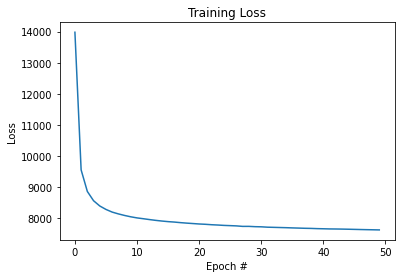

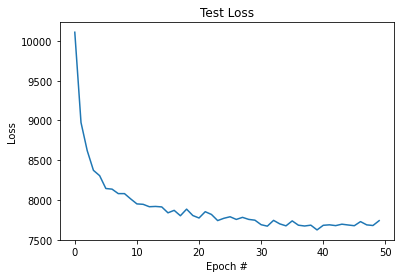

In [2]:

plt.plot(torch.tensor(avg_train_reconstruction_losses).to('cpu'))
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.show()

plt.plot(torch.tensor(avg_test_reconstruction_losses).to('cpu'))
plt.title('Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.show()
